In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import graphviz
import pandas
from IPython.display import Image

/var/folders/jn/zl4rcc1s56s5p6fm169l94mc0000gn/T/ipykernel_51489/1535956372.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was too old on your system - pyarrow 10.0.1 is the current minimum supported version as of this release.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas


# Goal
Here is the motivating question -  __`How do I know if my ACM Hub is gumming up. Do not talk about obvious things like CPU and Memory. Also do not talk about high level abstractions like SLO/SLI till we understand the motivating factors`.__

We will analyse this by:
- Goverance and Compliance Framework
- Observability
- Application Life Cyle
- Cluster Life cycle

## Goverance and Compliance Framework

### Sizing Estimates

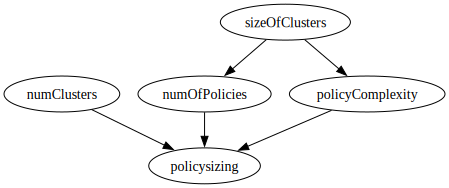

In [2]:
acmpolicycapacity=graphviz.Digraph()
acmpolicycapacity.edge('numClusters','policysizing')
acmpolicycapacity.edge('sizeOfClusters','numOfPolicies')
acmpolicycapacity.edge('numOfPolicies','policysizing')
acmpolicycapacity.edge('policyComplexity','policysizing')
acmpolicycapacity.edge('sizeOfClusters','policyComplexity')
acmpolicycapacity

_Note:_

1. _Size of clusters generally drives the number of policies but not always._
1. _Also the number of object templates per policy is an important factor though not shown in the drawing._

The above diagram captures the essence of what drives the sizing effort. Now lets look at what drives the runtime performance.

### Performance
#### Architecture

In [3]:
Image(url="https://access.redhat.com/webassets/avalon/d/Red_Hat_Advanced_Cluster_Management_for_Kubernetes-2.10-Governance-en-US/images/6bc4ca20d46e8611efd61714c692cfc3/governance_arch_2.8.png" ,height=100 )

#### Key components in the Governance Framework

|Srl|Controller|Location|Purpose|
|---| :- | :-| :- |
|1.|Policy Propagtor Controller|ACM Hub Server|Runs on the ACM hub cluster and generates the replicated policies in the managed cluster namespaces on the hub based on the placements bound to the root policy. It also aggregates compliance status from replicated policies to the root policy status and initiates automations based on policy automations bound to the root policy.|
|2.|Spec Sync Controller| Managed Cluster |Synchronizes the replicated policy in the managed cluster namespace on the hub cluster to the managed cluster namespace on the managed cluster.|
|3.|Status Sync Controller| Managed Cluster |Records compliance events from policy controllers in the replicated policies on the hub and managed cluster. The status only contains updates that are relevant to the current policy and does not consider past statuses if the policy is deleted and recreated.|
|4.|Template Sync Controller| Managed Cluster |Creates, updates, and deletes objects in the managed cluster namespace on the managed cluster based on the definitions from the replicated policy `spec.policy-templates` entries.|
|5.|Policy Controllers| Managed Cluster |These are controllers like Config Policy Policy Controller, Cert Policy Controller, IAM Policy Controller which does the actual policy reconciliation work. |


These Key controllers are critical for health of the GRC system. Though not shown in the drawing, all controllers depend on the __`health of the Kube API Servers`__ in ACM hub or Managed Cluster depending on the controller.


##### Policy Propagator Controller


__Latency__
1. controller_runtime_reconcile_time_seconds_bucket{controller="policy-propagator",le="10"} Latency can be determined by reconcile bucket not showing completed reconciles
1. Workqueue_queue_duration_seconds_bucket can also be used to show latency if queueing time is “long”.

__Throughput__
1. ocm_handle_root_policy_duration_seconds_bucket can be used to determine when root policy processing exceeds an expected threshold indicating a throughput problem

__Error Rate__
1. controller_runtime_reconcile_errors_total{controller="policy-encryption-keys"}
1. controller_runtime_reconcile_errors_total{controller="policy-propagator"}
1. controller_runtime_reconcile_errors_total{controller="policy-set"}
1. policy_propagation_failure_total - The Policy Propagator retries individual actions when an error is encountered. If too many retries occur, it gives up and requeues the entire request.  This metric will help detect this infinite requeue loop error condition.  

__Availability__
1. controller_runtime_reconcile_total{controller="policy-propagator",result="success"} should show reconciles complete as opposed to requeue or error results

__Summary__

|Metric Name|Owned By|
|---|---|
|controller_runtime_reconcile_time_seconds_bucket|Kubernetes|
|workqueue_queue_duration_seconds_bucket |Kubernetes|
|controller_runtime_reconcile_errors_total|Kubernetes|
|controller_runtime_reconcile_total|Kubernetes|
|ocm_handle_root_policy_duration_seconds_bucket|ACM|
|policy_propagation_failure_total|ACM|


##### Status Sync Controller

__Latency__

workqueue_depth{name="policy-status-sync"} - the number of events that could be policy status events that are waiting to be processed. If this is high, then the status updates will be slow to show up on the Hub.


__Throughput__

Not required for this controller.

__Error Rate__

controller_runtime_reconcile_errors_total{controller="policy-status-sync"} - The total number of errors when processing new statuses from the managed cluster policy controllers. If this is consistently high, this likely indicates that Policy status updates are not being sent back to the Hub.


__Availability__

workqueue_depth{name="policy-status-sync"} - the number of events that could be policy status events that are waiting to be processed. If this is high, then the controller is overwhelmed or stuck. Status updates will be slow.

__Summary__

|Metric Name|Owned By|
|---|---|
|workqueue_depth|Kubernetes|
|controller_runtime_reconcile_errors_total|Kubernetes|



##### Spec Sync Controller

__Latency__

workqueue_depth{name="policy-spec-sync"} - the number of policy changes that are waiting to be synced from the Hub. If this is high, then policy changes will be slow to reflect on the managed cluster. Policy updates are rather infrequent so if the queue gets large, that is signaling a larger problem.

__Throughput__

Not required for this controller.

__Error Rate__

controller_runtime_reconcile_errors_total{controller="policy-spec-sync"} - The total number of errors when syncing updates to policies from the Hub to the managed cluster. If this is consistently high, this likely indicates an outage.

Other Errors:

- User errors: policy_user_errors_total - for Invalid syntax
- System errors: policy_system_errors_total - for API failures (e.g. can’t watch a dependency)


__Availability__

workqueue_depth{name="policy-spec-sync"} - the number of policy changes that are waiting to be synced from the Hub. If this is high, then the controller is overwhelmed or stuck.

__Summary__

|Metric Name|Owned By|
|---|---|
|workqueue_depth|Kubernetes|
|controller_runtime_reconcile_errors_total|Kubernetes|
|policy_user_errors_total|ACM|
|policy_system_errors_total|ACM|


##### Template Sync Controller

__Latency__

workqueue_depth{name="policy-template-sync"} - the number of policy templates (e.g. ConfigurationPolicy) that are awaiting to be created/updated on the managed cluster from the synced replicated policies. If this is high, then policy changes will be slow to reflect on the managed cluster. Policy updates are rather infrequent so if the queue gets large, that is signaling a larger problem.


__Throughput__

Not required for this controller.

__Error Rate__

controller_runtime_reconcile_errors_total{controller="policy-spec-sync"} - The total number of errors when syncing updates to policies from the Hub to the managed cluster. If this is consistently high, this likely indicates an outage.


Other Errors:

Have metrics for policy-template-sync errors that must be distinguishable by:
- User errors: policy_user_errors_total - for Invalid syntax
- System errors: policy_system_errors_total - for API failures (e.g. can’t watch a dependency)



__Availability__

workqueue_depth{name="policy-template-sync"} - the number of policy templates (e.g. ConfigurationPolicy) that are awaiting to be created/updated on the managed cluster from the synced replicated policies. If this is high, then the controller is overwhelmed or stuck.


|Metric Name|Owned By|
|---|---|
|workqueue_depth|Kubernetes|
|controller_runtime_reconcile_errors_total|Kubernetes|
|policy_user_errors_total|ACM|
|policy_system_errors_total|ACM|


##### Policy Controller - Config Policy Controller

__Latency__

config_policy_evaluation_seconds_total - The total seconds taken while evaluating the configuration policy. Use this alongside config_policy_evaluation_total. This allows you to detect Configuration Policies that are slow and maybe causing excessive load on the Kubernetes API server.


__Throughput__

config_policies_evaluation_duration_seconds - The seconds that it takes to evaluate all configuration policies that are ready for evaluation on the cluster. A value over 10 seconds starts to indicate some level of saturation. Use this in conjunction with config_policies_evaluation_duration_seconds_sum for an average.


__Error Rate__

- User errors: policy_user_errors_total - for Invalid syntax
- System errors: policy_system_errors_total - for API failures (e.g. can’t watch a dependency)

__Availability__

config_policy_evaluation_total - The total number of evaluations per policy. If this time series does not have a value in the past N seconds, it means there is an outage. N would be the shortest evaluation interval (defaults to 10s) of all the configured policies.

__Summary__

|Metric Name|Owned By|
|---|---|
|config_policy_evaluation_total|ACM|
|config_policy_evaluation_seconds_total|ACM|
|config_policies_evaluation_duration_seconds|ACM|
|config_policies_evaluation_duration_seconds_sum|ACM|
|policy_user_errors_total|ACM|
|policy_system_errors_total|ACM|


#### Dependency Flows

Policy Creation Flow

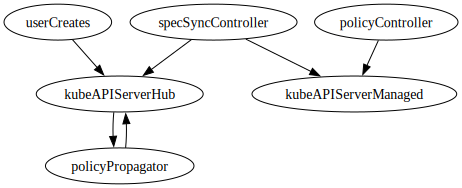

In [4]:
acmpolicycreation=graphviz.Digraph()
acmpolicycreation.edge('userCreates','kubeAPIServerHub')
acmpolicycreation.edge('kubeAPIServerHub','policyPropagator')
acmpolicycreation.edge('policyPropagator','kubeAPIServerHub')
acmpolicycreation.edge('specSyncController','kubeAPIServerHub')
acmpolicycreation.edge('specSyncController','kubeAPIServerManaged')
acmpolicycreation.edge('policyController','kubeAPIServerManaged')
acmpolicycreation

Policy Status Update Flow

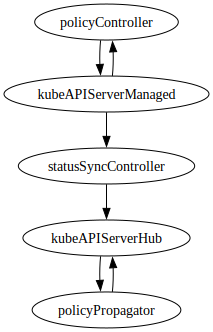

In [5]:
acmpolicystatusupdate=graphviz.Digraph()
acmpolicystatusupdate.edge('policyController','kubeAPIServerManaged')
acmpolicystatusupdate.edge('kubeAPIServerManaged','policyController')
acmpolicystatusupdate.edge('kubeAPIServerManaged','statusSyncController')
acmpolicystatusupdate.edge('statusSyncController','kubeAPIServerHub')
acmpolicystatusupdate.edge('kubeAPIServerHub','policyPropagator')
acmpolicystatusupdate.edge('policyPropagator','kubeAPIServerHub')
acmpolicystatusupdate

## Observability